In [ ]:
try:
    from google.colab import drive
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/NUIN/CBEM_pytorch
    # !pip install -r requirements.txt
    # Uninstall CPU jax/jaxlib if present
    # !pip uninstall -y jax jaxlib

    # # Install GPU-enabled JAX (choose the right cuda extra for your Colab)
    # # Try cuda12 first (common in Colab recently):
    # !pip install -U "jax[cuda12]"
else: 

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils._raised_cosine_basis import makeRaisedCosBasis
from utils.load_matlab import load_mat_v73, flatten_cell
import torch.nn.functional as F
import h5py
import math
import torch.nn as nn

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch: 2.10.0+cu128
CUDA available: False


In [48]:
# from utils.stim_utils import generate_1_f_noise, plot_stim
# beta= 0
# mean_intensity = 0.15
# desired_contrast = 0.3
# stim_duration = 5
# trials = 10
# frame_rate = 60
# dt_stim = 1/frame_rate
# frame_dwell = 1
# tau = 10

# all_noise = []
# all_contrast = []
# for trial in range(trials):
#     noise, contrast = generate_1_f_noise(
#         beta, frame_rate * stim_duration, frame_rate,
#         frame_dwell, mean_intensity, desired_contrast,
#         noise_seed=trial)
#     all_noise.append(noise)
#     all_contrast.append(contrast)

# noise_t = np.concatenate(all_noise)
# contrast_t = np.concatenate(all_contrast)
# stim = np.array(all_contrast)

# plot_stim(noise_t=noise_t, contrast_mat=stim,
#           beta=beta,
#           mean_intensity=mean_intensity,
#           desired_contrast=desired_contrast,
#           tau=10, frame_rate=60, figsize=(16,7))

In [49]:
# load stimulus and spike times from the matlab file
filename = "Data/example.mat"
with h5py.File(filename, "r") as f:
    # Get the data
    stimulus  = np.array(list(f["X"]))[0]
    spkVector = np.array(list(f["Y"]))[0]
    CBEM_True = np.array(list(f["CBEM_true"]))
spkTimes_bins = np.where(spkVector > 0)[0]
spkTimes_bins = torch.as_tensor(spkTimes_bins, dtype=torch.long)

In [50]:
cbem = load_mat_v73("Data/example.mat", "CBEM_true")

In [51]:
dt      = float(cbem["dt"])
E_l     = float(cbem["E_l"])
initV   = float(cbem["initV"])
g_l     = float(cbem["g_l"])
log_g_l = float(cbem["log_g_l"])

E_s     = np.array(cbem["E_s"]).squeeze()
g_s_bar = np.array(cbem["g_s_bar"]).squeeze()

stimBasisVectors = np.array(cbem["stimBasisVectors"])
spkHistBasisVectors = np.array(cbem["spkHistBasisVectors"])

k_s_list = [np.array(x).squeeze() for x in flatten_cell(cbem["k_s"])]
print(len(k_s_list), [ks.shape for ks in k_s_list])

3 [(11,), (11,), ()]


In [52]:

dt = float(cbem["dt"])  # seconds (in your CBEM_true)
stimBasisVectors = np.array(cbem["stimBasisVectors"]).T   # [L, P]
stimNumBasisVectors = int(np.squeeze(cbem["stimNumBasisVectors"]))

# k_s{1} as a 1D array
# (if you used the flatten_cell helper from earlier)
k_e = np.array(k_s_list[0]).squeeze()
k_i = np.array(k_s_list[1]).squeeze()

print(k_e.shape, k_i.shape)
# MATLAB: k_s{1}(1:stimNumBasisVectors)
k_e = k_e[:stimNumBasisVectors]   # Python is 0-indexed
k_i = k_i[:stimNumBasisVectors]
L = stimBasisVectors.shape[0]

(11,) (11,)


In [53]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4

RFstart = 2e-3 #;%0?
RFend   = 150e-3#;%150e-3 or 180e-3;
b = 0.02
t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
B_orth.shape

(2478, 10)

In [54]:

f_e_mat = stimBasisVectors @ k_e
f_i_mat = stimBasisVectors @ k_i

k_e_py = B_orth.T @ f_e_mat
k_i_py = B_orth.T @ f_i_mat
f_e_py = B_orth @ k_e_py
f_i_py = B_orth @ k_i_py


In [55]:
condType = np.array(cbem["condType"]).squeeze().astype(int)   # MATLAB uses 1,2,3,...
g_s_bar  = np.array(cbem["g_s_bar"]).squeeze().astype(np.float32)
E_s      = np.array(cbem["E_s"]).squeeze().astype(np.float32)

# In MATLAB: condType==2 means stimulus-driven conductance
stim_cond_inds = np.where(condType == 2)[0]
print("stim cond inds:", stim_cond_inds, "nConds:", len(condType))

stim cond inds: [0 1] nConds: 3


# Our sim

In [56]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4 
dt_ms = dt*1000
# dt_ms =  0.1
RFstart = 2e-3 #2ms in s
RFend   = 150e-3#%150ms in s
b = 0.02
t, basis_v_o, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
stimulus_t = torch.as_tensor(stimulus, dtype=torch.float32)
basis_v_ot = torch.as_tensor(basis_v_o, dtype=torch.float32)

In [57]:
import torch
import torch.nn.functional as F
import math

def convolveStimulusWithBasis_torch(stimulus: torch.Tensor, basis: torch.Tensor, add_ones: bool = True):
    if stimulus.ndim == 1:
        stimulus = stimulus[:, None]  # [T, Npix]
    T, Npix = stimulus.shape
    L, P = basis.shape                                  # basis: [Lags, #basis vectors]

    x = stimulus.transpose(0, 1).unsqueeze(1)           # [Npix, 1, T]
    w = basis.transpose(0, 1).flip(1).unsqueeze(1)      # [P, 1, L]

    # y = F.conv1d(F.pad(x, (L, 0)), w)                   # [Npix, P, T+1]
    # y = y[..., :T]                                      # -> [Npix, P, T]
    y = F.conv1d(F.pad(x, (L-1, 0)), w)   # -> length T

    X = y.permute(2, 0, 1).reshape(T, Npix * P)         # [T, Npix*P]

    if add_ones:
        X = torch.cat([X, torch.ones(T, 1, device=X.device, dtype=X.dtype)], dim=1)
    return X

# def log_one_plus_exp_x(x, gbar, clamp=80.0):
    
#     return gbar * F.softplus(x, threshold=clamp)   # gbar * softplus(x) #defualt is 20 so may need to change it!

def logOnePlusExpX_torch(x, maxG):
    """
    Match MATLAB logOnePlusExpX.m

    x:    [T, nConds] or [T]
    maxG: scalar or [nConds] broadcastable to x
    """
    # ensure tensor
    x = torch.as_tensor(x)
    maxG = torch.as_tensor(maxG, device=x.device, dtype=x.dtype)

    # broadcast maxG to x shape if needed
    while maxG.ndim < x.ndim:
        maxG = maxG.unsqueeze(0)

    f = x.clone()

    lessT = x <= -30.0
    greaterT = x >= maxG
    toFit = (~lessT) & (~greaterT)

    # log(1+exp(x)) safely
    f[toFit] = F.softplus(x[toFit])          # softplus = log(1+exp)
    f[lessT] = 1e-15
    # f[greaterT] already equals x

    return f

def get_voltage_exp_recurrence(gs, E_s, g_l, E_l, V0, dt_s, eps=1e-12):
    """
    Single-compartment exponential (exact) update for piecewise-constant conductances per bin.

    gs:   [T, C] conductances (>=0)
    E_s:  [C] reversal potentials
    g_l:  scalar leak conductance
    E_l:  scalar leak reversal
    V0:   scalar initial voltage. In paper they initialize as E_l
    dt_s: bin size in seconds

    Returns:
      V: [T]
    """
    # totals
    g_tot = g_l + gs.sum(dim=1)                        # [T]
    I_tot = E_l * g_l + gs @ E_s                       # [T]   (sum g*E)

    # V_inf(t) = I_tot / g_tot
    V_inf = I_tot / (g_tot + eps)                      # [T]

    # a(t) = exp(-dt*g_tot)
    a = torch.exp(-dt_s * g_tot)                       # [T] in (0,1] if g_tot>=0

    V = torch.empty_like(g_tot)
    v_prev = torch.as_tensor(V0, device=gs.device, dtype=gs.dtype)
    ## THIS IS GONNA BE SLOWW
    for t in range(gs.shape[0]):
        v_prev = a[t] * v_prev + (1.0 - a[t]) * V_inf[t]
        V[t] = v_prev
    return V

def get_voltage_matlab_form(gs, E_s, g_l, E_l, initVoltage, dt, EXP_MAX=500.0, eps=1e-12):
    # g_l = torch.exp(log_g_l)

    c = g_l + gs.sum(dim=1)                 # [T]
    b = g_l * E_l + gs @ E_s                # [T]
    bc = b / (c + eps)

    exc = torch.exp(torch.clamp(c * dt, max=EXP_MAX))  # <-- dt in seconds (same as CBEM.dt)
    I = bc * (exc - 1.0)

    I = I.clone()
    I[0] = I[0] + initVoltage               # <-- MATLAB injects initVoltage into I(1)

    V = torch.empty_like(I)
    V[0] = I[0] / exc[0]
    for t in range(1, I.shape[0]):
        V[t] = (I[t] + V[t-1]) / exc[t]
    return V

def firingRateNonlinearity(V_t, alpha, mu, beta):
    """ 
    Computes the firing rate nonlinearity on the given total voltage.
        The nonlinearity is alpha * softplus((V_tot - mu)/beta)
    From Mensi et al. 2011(From stochastic NL IF to GLMS)
    """
    return alpha * F.softplus((V_t - mu)/beta)
    

class CBEM(nn.Module):
    def __init__(self, binsize_s: float, basis_conductance: torch.Tensor,
                 gbar_exc: float = 80.0, gbar_inh: float = 80.0,
                 E_l: float = -60.0, g_l: float = 200.0, V0: float | None = None,
                 alpha: float = 90.0, beta: float = 1.67, mu: float = -53.0,
                 add_ones: bool = True):
        super().__init__()
        self.binsize_s = float(binsize_s)
        self.add_ones = bool(add_ones)

        # basis is fixed -> buffer (moves with device, saved in state_dict)
        if basis_conductance.ndim == 1:
            basis_conductance = basis_conductance[:, None]
        self.register_buffer("basis_conductance", basis_conductance.float())  # [L, P]

        # fixed biophysics as buffers (or Parameters if you want to train them)
        self.register_buffer("E_s", torch.tensor([0.0, -80.0], dtype=torch.float32))  # [2]
        self.register_buffer("E_l", torch.tensor(E_l, dtype=torch.float32))
        self.register_buffer("g_l", torch.tensor(g_l, dtype=torch.float32))
        self.register_buffer("V0", torch.tensor(E_l if V0 is None else V0, dtype=torch.float32))

        # gbar could be fixed or trainable; here fixed
        self.register_buffer("gbar", torch.tensor([gbar_exc, gbar_inh], dtype=torch.float32))  # [2]

        # firing nonlinearity params: often trainable in CBEM fits
        # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        # self.beta  = nn.Parameter(torch.tensor(beta, dtype=torch.float32))
        # self.mu    = nn.Parameter(torch.tensor(mu, dtype=torch.float32))
        
        self.register_buffer("alpha",  torch.tensor(alpha, dtype=torch.float32))
        self.register_buffer("beta",  torch.tensor(beta, dtype=torch.float32))
        self.register_buffer("mu",  torch.tensor(mu, dtype=torch.float32))


        # Conductance weights B_cond depend on stimulus dimensionality (Npix),
        # so we initialize lazily on first forward.
        self.B_cond = None  # will become nn.Parameter of shape [(P*Npix+1), 2]
        
    def _maybe_init_B_cond(self, Npix: int, device, dtype):
        if self.B_cond is not None:
            return
        P = self.basis_conductance.shape[1]
        D = P * Npix + (1 if self.add_ones else 0)
        # small init helps
        self.B_cond = nn.Parameter(torch.zeros(D, 2, device=device, dtype=dtype))

    def conductances_from_X(self, X_cond: torch.Tensor) -> torch.Tensor:
        """
        X_cond: [T, D]
        returns gs: [T, 2]
        """
        x = X_cond @ self.B_cond  # [T,2]
        # MATLAB style saturating softplus
        return logOnePlusExpX_torch(x, self.gbar.to(device=x.device, dtype=x.dtype))

    def voltage(self, gs: torch.Tensor) -> torch.Tensor:
        E_s = self.E_s.to(device=gs.device, dtype=gs.dtype)
        return get_voltage_exp_recurrence(
            gs, E_s,
            g_l=self.g_l.to(device=gs.device, dtype=gs.dtype),
            E_l=self.E_l.to(device=gs.device, dtype=gs.dtype),
            V0=self.V0.to(device=gs.device, dtype=gs.dtype),
            dt_s=self.binsize_s,
        )

    def forward(self, stimulus: torch.Tensor, window=None):
        """
        stimulus: [T, Npix] OR [T, H, W] (we flatten if needed)
        window: optional indices to subset time bins (e.g. training window)

        returns:
          rate: [T_window] (or [T] if no window)
          extras: dict with V, gs, X_cond if you want
        """
        if stimulus.ndim == 3:
            T, H, W = stimulus.shape
            stimulus = stimulus.reshape(T, H * W)
        elif stimulus.ndim == 1:
            stimulus = stimulus[:, None]

        T, Npix = stimulus.shape
        stimulus = stimulus.float()

        X = convolveStimulusWithBasis_torch(stimulus, self.basis_conductance, add_ones=self.add_ones)  # [T, D]
        if window is not None:
            window = torch.as_tensor(window, device=X.device, dtype=torch.long)
            X_cond = X[window]
        else:
            X_cond = X

        self._maybe_init_B_cond(Npix, device=X_cond.device, dtype=X_cond.dtype)

        gs = self.conductances_from_X(X_cond)        # [T_w,2]
        V  = self.voltage(gs)                        # [T_w]
        rate = 1e-4 + firingRateNonlinearity(V, self.alpha, self.mu, self.beta)  # [T_w]

        extras = {"V": V, "gs": gs, "X_cond": X_cond}
        return rate, extras

   

In [58]:
def poisson_nll_truncated_from_spike_bins(rate: torch.Tensor,
                                         spkTimes_bins: torch.Tensor,
                                         binsize_s: float) -> torch.Tensor:
    """
    Truncated-Poisson / Bernoulli-per-bin likelihood.
     Based on Citi et. al 2014: product of T bernoulli trials. Works if max 1 spk/bin
    logp
    \log_p(y_{1:T}\mid \textbf{x}_{1:T}, \Theta ) = 
    \sum_{t=1}^T y_t \log(1- \exp(-\lambda_t \Delta ))-(1- y_t)\lambda_t\Delta
    
    Args:
    rate: [T] firing rate in spikes/second (Hz)
    binsize_s: seconds per bin (self.binsize_s)
    spkTimes_bins: indices (0..T-1) of bins that contain a spike (or >=1 spike)

    Log-likelihood per bin:
      ll_t = -lam_t                                  if y_t = 0
      ll_t = log(1 - exp(-lam_t))                    if y_t = 1
    where lam_t = rate_t * binsize_s  (expected count in bin)

    Returns:
      nll: scalar negative log-likelihood (sum over bins)
    """
    lam = rate * binsize_s              # [T]
    ll = -lam                           # default no-spike ll

    spk_idx = torch.as_tensor(spkTimes_bins, device=rate.device, dtype=torch.long)
    spk_idx = spk_idx[(spk_idx >= 0) & (spk_idx < lam.shape[0])]
    if spk_idx.numel() > 0:
        spk_idx = torch.unique(spk_idx)

        # stable log(1 - exp(-lam))
        spike_ll = torch.log1p(-torch.exp(-lam[spk_idx]).clamp(max=1 - 1e-12))
        ll = ll.clone()
        ll[spk_idx] = spike_ll

    return -ll.sum()

def cbem_penalized_nll(model,
                       stimulus: torch.Tensor,
                       spkTimes_bins: torch.Tensor,
                       window=None,
                       conductance_penalty=(1.0, 0.2)) -> torch.Tensor:
    """
    Penalized NLL:
      nll = truncated_poisson_nll(rate)
      + sum_c pen[c] * ||B_cond[:-1, c]||^2

    Excludes last row of B_cond (baseline term), matching JAX.
    """
    rate, _ = model(stimulus, window=window)  # calls forward
    nll = poisson_nll_truncated_from_spike_bins(rate, spkTimes_bins, model.binsize_s)

    B = model.B_cond
    if B is None:
        raise RuntimeError("model.B_cond is None. Run model once to initialize B_cond.")

    W = B[:-1, :]  # exclude baseline row
    pen = torch.as_tensor(conductance_penalty, device=W.device, dtype=W.dtype)  # [2]

    # generic form (works even if you later change #conductances)
    if pen.numel() != W.shape[1]:
        raise ValueError(f"conductance_penalty has {pen.numel()} elements but B_cond has {W.shape[1]} columns.")

    nll = nll + (pen * (W**2).sum(dim=0)).sum()
    return nll

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_87953/1430219121.py:8: SyntaxWarning: invalid escape sequence '\l'
  \log_p(y_{1:T}\mid \textbf{x}_{1:T}, \Theta ) =


## Main API 

In [59]:
import torch

# stimulus_t: shape [T] or [T,1] — both are fine with your forward
stimulus_t = torch.as_tensor(stimulus, dtype=torch.float32)

window = range(0, 70000)
t0 = window.start  # 0 here, but keep general

# IMPORTANT: use LONG indices, and make them relative to window start
spkTimes_bins = torch.as_tensor(spkTimes_bins, dtype=torch.long)
spkTimes_w = spkTimes_bins[(spkTimes_bins >= t0) & (spkTimes_bins < window.stop)] - t0

In [ ]:
model = CBEM(binsize_s=1e-4, basis_conductance=basis_v_ot)
model = model.to(device)
stimulus_t = stimulus_t.to(device)
spkTimes_w = spkTimes_w.to(device)
# Trigger lazy init of B_cond BEFORE creating optimizer
_ = model(stimulus_t[:200], window=range(0, 200))
print("B_cond shape:", model.B_cond.shape)  # should be [11,2] for your example

B_cond shape: torch.Size([11, 2])


In [63]:
import torch.optim as optim

opt = optim.Adam([model.B_cond], lr=1e-2)  # explicitly optimize B_cond

for it in range(1000):
    opt.zero_grad()

    loss = cbem_penalized_nll(
        model,
        stimulus_t,
        spkTimes_w,
        window=window,
        conductance_penalty=(1.0, 0.2),
    )

    loss.backward()
    opt.step()

    if it % 50 == 0:
        print(it, float(loss.detach().cpu()))

0 2084.811767578125


: 

: 

In [1]:
print(stimulus_t.shape, spkTimes_bins[:10], spkTimes_w[:10], window.start, window.stop)

NameError: name 'stimulus_t' is not defined

## Misc

In [30]:
window = range(0,70000); # range of bins to use 
model = CBEM(binsize_s=1e-4, basis_conductance=basis_v_ot)
# opt = torch.optim.Adam(model.parameters(), lr=1e-2)


In [31]:
print("stimulus_t shape:", stimulus_t.shape)  # expect [T, Npix]

# Run once to trigger lazy init of B_cond
_ = model(stimulus_t[:200], window=range(0, 200))
print("model.B_cond shape:", model.B_cond.shape)

stimulus_t shape: torch.Size([71000])
model.B_cond shape: torch.Size([11, 2])


In [32]:
k0 = torch.tensor(k_s_list[0])  # len 11
k1 = torch.tensor(k_s_list[1])  # len 11
B_cond = torch.stack([k0, k1], dim=1)                    # [11, 2]
# make sure dtype/device match the existing parameter
with torch.no_grad():
    model.B_cond.copy_(B_cond.to(device=model.B_cond.device, dtype=model.B_cond.dtype))

In [33]:
Fr, extras = model(stimulus_t, window=window)
Fr = Fr.detach().numpy()

In [34]:
gs = extras['gs'].detach().numpy()
Vm = extras['V'].detach().numpy()
X_cond = extras['X_cond'].detach().numpy()

In [35]:

# loss = model.poisson_nll_from_spike_bins(rate, spkTimes_bins)
# loss.backward()
# opt.step()

/tmp/ipykernel_87953/814829829.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


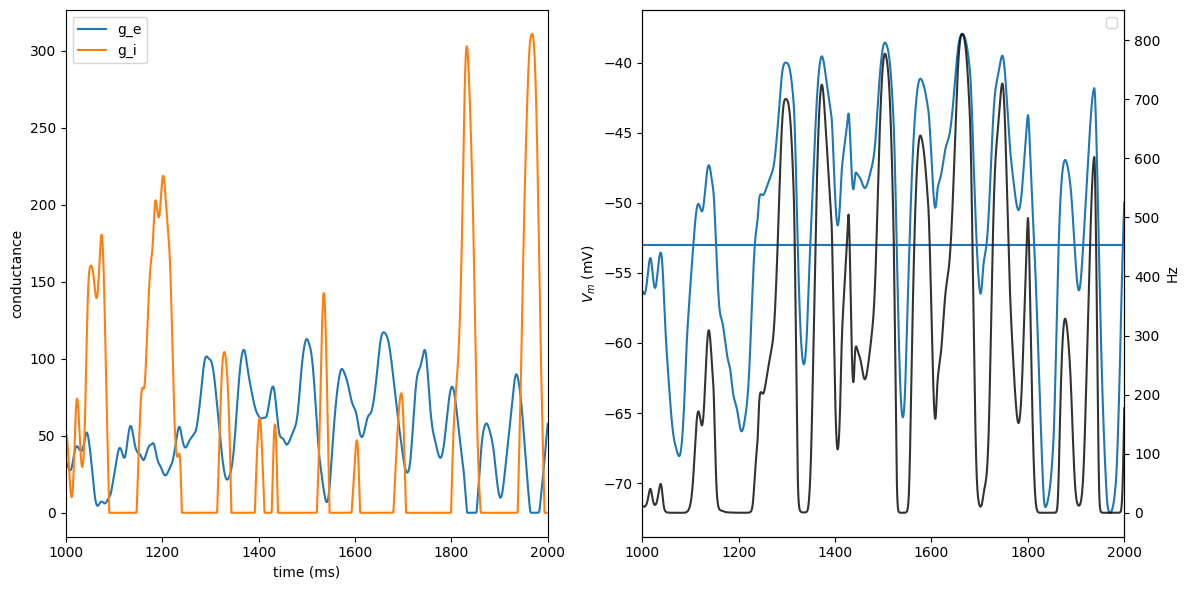

In [43]:
## General shape is okay but we are off but a scale factor and not including the leak conductance!!
pltLength_bins = 20000
t_ms = np.arange(pltLength_bins)*dt*1e3 
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(t_ms, gs[0:pltLength_bins,:], label=["g_e", "g_i"])
# axes[0].plot(t_ms, Fr[0:pltLength_bins], label='Spike Rate', c='k', alpha =0.8)
axes[0].set_xlabel('time (ms)')
axes[0].set_ylabel('conductance')

axes[1].plot(t_ms, Vm[:pltLength_bins])
axes[1].axhline(-53)
axes[1].set_ylabel(r'$V_m \text{ (mV)}$')
rate_ax = axes[1].twinx()
rate_ax.plot(t_ms, Fr[0:pltLength_bins], label='Spike Rate', c='k', alpha =0.8)
rate_ax.set_ylabel("Hz")
for ax in axes:
    ax.set_xlim(1000,2000)
    ax.legend()
fig.tight_layout()
plt.show()

## This is super similar to MATLAB's!!

TO DO:
- Check that voltage is okay --> **DONE**
- Implement leak conductance. Though I'm not sure any of it is a learnable param. 
- Ensure time constant is 4ms
- Once Vm works, check spike rate nonlinearity. 
- Then loglikelihood, fitting AND initialization!

In [ ]:


X_np = np.array(cbem.X_cond[:20000,:])   # or: jax.device_get(X_cond_jax)
plt.figure(figsize=(8,4))
plt.imshow(X_np, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title("Design matrix (Stim projected onto basis f)")
plt.xlabel("features")
plt.ylabel("time bin")
plt.show()


# x_e = X_cond @ k_e + bias_e

# g_e = logOnePlusExpX_torch(x_e, g_s_bar_e)

# same for g_i

# V = solve_voltage_implicit(g_e, g_i, dt, g_l, ...)

# sph = X_hspk @ h_spk

# lam = softrec_rate(V, sph, ...)

# loss = NLL(lam, y) + penalties/priors

In [ ]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4

RFstart = 2e-3 #;%0?
RFend   = 150e-3#;%150e-3 or 180e-3;
b = 0.02
t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
stimulus_t = torch.as_tensor(stimulus, dtype=torch.float32)
B_orth_t   = torch.as_tensor(B_orth,   dtype=torch.float32)

X_cond = convolveStimulusWithBasis_torch(stimulus_t, B_orth_t)
# CBEM.stimNumBasisVectors = size(CBEM.stimBasisVectors,2);
stimNumBasisVectors = B_orth.shape[1]

plt.figure()
plt.plot(t, B_raw)
plt.xlabel("Lag (s)")
plt.ylabel("Basis value")
plt.title("Raised-cosine log-time basis (raw)")
plt.show()

plt.figure()
plt.plot(t, B_orth)
plt.xlabel("Lag (s)")
plt.ylabel("Basis value")
plt.title("Raised-cosine basis after orthonormalization (SVD)")
plt.show()